In [18]:
import sys
!{sys.executable} -c "import torch; print(torch.__version__)"
!{sys.executable} -c "import torch; print(torch.version.cuda)"

1.11.0+cu102
10.2


In [ ]:
import sys

!{sys.executable} -m pip install -q networkx ipdb scipy cilog typed-argument-parser==1.5.4 captum==0.2.0 shap ipython tqdm rdkit-pypi pandas sympy hydra-core
!{sys.executable} -m pip install -q dive-into-graphs
!{sys.executable} -m pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
!{sys.executable} -m pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
!{sys.executable} -m pip install -q torch-geometric

     |████████████████████████████████| 1.4 MB 13.4 MB/s 
     |████████████████████████████████| 564 kB 51.9 MB/s 
     |████████████████████████████████| 22.5 MB 1.2 MB/s 
     |████████████████████████████████| 147 kB 62.4 MB/s 
     |████████████████████████████████| 793 kB 62.9 MB/s 
     |████████████████████████████████| 381 kB 69.6 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 112 kB 65.5 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.
     |████████████████████████████████| 4.1 MB 8.1 MB/s 
     |████████████████████████████

In [19]:
DATA_PATH = f'/mnt/infonas/data/pritish/cs726'

In [20]:
!wget -O $DATA_PATH/config.csv https://www.dropbox.com/s/va3ulx8i82xvk9m/config.csv?dl=0 # config file for DIG to work

--2022-05-05 23:49:17--  https://www.dropbox.com/s/va3ulx8i82xvk9m/config.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/va3ulx8i82xvk9m/config.csv [following]
--2022-05-05 23:49:18--  https://www.dropbox.com/s/raw/va3ulx8i82xvk9m/config.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccebef241bc8a080f73f64c66a9.dl.dropboxusercontent.com/cd/0/inline/Bksl7aD0j93xVpar3UwHHj00iBf7v3YknM-Cknehz97R3byCop2eLVIimgdyYuSL4EACFOqcVSQRZm-p8q_Cczy5w8IQIvDZ0kVeuygXeua1qsSlaDG1gmZ32wRy8PuSfpUAVilssMbzEQApGM8trddyU29iBDSHFtvkSrVvLcUl3w/file# [following]
--2022-05-05 23:49:18--  https://uccebef241bc8a080f73f64c66a9.dl.dropboxusercontent.com/cd/0/inline/Bksl7aD0j93xVpar3UwHHj00iBf7v3YknM-Cknehz97R3byCop2eLVIimgdyYuSL4E

In [21]:
import os
import torch
from torch_geometric.data import DenseDataLoader
from rdkit import RDLogger
import torch.nn as nn
import torch

from dig.ggraph.dataset import ZINC250k, ZINC800
from dig.ggraph.method import GraphEBM
from dig.ggraph.evaluation import PropOptEvaluator, ConstPropOptEvaluator

import numpy as np

In [22]:
torch.manual_seed(1)
np.random.seed(1)

In [23]:
device = torch.device('cuda:2')

In [24]:
CHECKPT_DIR = os.path.join(DATA_PATH, 'checkpoints_goal')
os.makedirs(CHECKPT_DIR, exist_ok=True)

In [25]:
import os, torch, json, ast
import os.path as osp
import ssl
from itertools import repeat
import numpy as np
from rdkit import Chem
import pandas as pd
import networkx as nx
from six.moves import urllib
from torch_geometric.data import Data, InMemoryDataset, download_url

bond_type_to_int = {Chem.BondType.SINGLE: 0, Chem.BondType.DOUBLE: 1, Chem.BondType.TRIPLE: 2}
zinc_atom_list = [6, 7, 8, 9, 15, 16, 17, 35, 53]
qm9_atom_list = [6, 7, 8, 9]


class MultiPropDataset(InMemoryDataset):
    """
    Redefine PygDataset from the DIG library so that it is able to take and
    store multiple properties rather than the single property. We shall use this
    aspect during goal-directed generation to combine properties during
    training.
    """
    
    def __init__(self,
                 root,
                 name,
                 prop_names=None,
                 conf_dict=None,
                 transform=None,
                 pre_transform=None,
                 pre_filter=None,
                 processed_filename='data.pt',
                 use_aug=False,
                 one_shot=False
                 ):
        
        self.processed_filename = processed_filename
        self.root = root
        self.name = name
        if prop_names is None:
            prop_names = []
        self.prop_names = prop_names
        self.use_aug = use_aug
        self.one_shot = one_shot
        
        if conf_dict is None:                        
            config_file = pd.read_csv(os.path.join(DATA_PATH, 'config.csv'), index_col = 0)
            if not self.name in config_file:
                error_mssg = 'Invalid dataset name {}.\n'.format(self.name)
                error_mssg += 'Available datasets are as follows:\n'
                error_mssg += '\n'.join(config_file.keys())
                raise ValueError(error_mssg)
            config = config_file[self.name]
            
        else:
            config = conf_dict
            
        self.url = config['url']
        #self.available_props = \
        #    np.array(prop_names) == np.array(ast.literal_eval(config['prop_list']))
        self.smile_col = config['smile']
        self.num_max_node = int(config['num_max_node'])
        self.atom_list = ast.literal_eval(config['atom_list'])
            
        super().__init__(root, transform, pre_transform, pre_filter)
        if not osp.exists(self.raw_paths[0]):
            self.download()
        if osp.exists(self.processed_paths[0]):
            self.data, self.slices, self.all_smiles = torch.load(self.processed_paths[0])
        else:
            self.process()
        
        if self.one_shot:
            self.atom_list = ast.literal_eval(config['atom_list'])+[0]

    @property
    def raw_dir(self):
        name = 'raw'
        return osp.join(self.root, name)
    
    @property
    def processed_dir(self):
        name = 'processed'
        if self.one_shot:
            name = 'processed_'+'oneshot'
        return osp.join(self.root, self.name, name)

    @property
    def raw_file_names(self):
        name = self.name + '.csv'
        return name

    @property
    def processed_file_names(self):
        return self.processed_filename
    
    def download(self):
        print('making raw files:', self.raw_dir)
        if not osp.exists(self.raw_dir):
            os.makedirs(self.raw_dir)
        url = self.url
        path = download_url(url, self.raw_dir)

    def process(self):
        r"""Processes the dataset from raw data file to the :obj:`self.processed_dir` folder.
        
            If one-hot format is required, the processed data type will include an extra dimension of virtual node and edge feature.
        """
        
        print('Processing...')
        if self.one_shot:
            self.data, self.slices = self.one_shot_process()
        else:
            self.data, self.slices = self.pre_process()

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)
        
        print('making processed files:', self.processed_dir)
        if not osp.exists(self.processed_dir):
            os.makedirs(self.processed_dir)
            
        torch.save((self.data, self.slices, self.all_smiles), self.processed_paths[0])
        print('Done!')
        
    def __repr__(self):
        return '{}({})'.format(self.name, len(self))
    
    def get(self, idx):
        r"""Gets the data object at index :idx:.
        
        Args:
            idx: The index of the data that you want to reach.
        :rtype: A data object corresponding to the input index :obj:`idx` .
        """
        data = self.data.__class__()

        if hasattr(self.data, '__num_nodes__'):
            data.num_nodes = self.data.__num_nodes__[idx]

        for key in self.data.keys:
            item, slices = self.data[key], self.slices[key]
            if torch.is_tensor(item):
                s = list(repeat(slice(None), item.dim()))
                s[self.data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            else:
                s = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
            
        data['smile'] = self.all_smiles[idx]
        
        if not self.one_shot:
            # bfs-searching order
            mol_size = data.num_atom.numpy()[0]
            pure_adj = np.sum(data.adj[:3].numpy(), axis=0)[:mol_size, :mol_size]
            if self.use_aug:
                local_perm = np.random.permutation(mol_size)
                adj_perm = pure_adj[np.ix_(local_perm, local_perm)]
                G = nx.from_numpy_matrix(np.asmatrix(adj_perm))
                start_idx = np.random.randint(adj_perm.shape[0])
            else:
                local_perm = np.arange(mol_size)
                G = nx.from_numpy_matrix(np.asmatrix(pure_adj))
                start_idx = 0

            bfs_perm = np.array(self._bfs_seq(G, start_idx))
            bfs_perm_origin = local_perm[bfs_perm]
            bfs_perm_origin = np.concatenate([bfs_perm_origin, np.arange(mol_size, self.num_max_node)])
            data.x = data.x[bfs_perm_origin]
            for i in range(4):
                data.adj[i] = data.adj[i][bfs_perm_origin][:,bfs_perm_origin]
            
            data['bfs_perm_origin'] = torch.Tensor(bfs_perm_origin).long()

        return data

    def pre_process(self):
        """
        One of the methods modified so that we store all possible available
        properties.
        """
        input_path = self.raw_paths[0]
        input_df = pd.read_csv(input_path, sep=',', dtype='str')
        smile_list = list(input_df[self.smile_col])
        if self.prop_names: # is not empty
            prop_list = np.array(input_df[self.prop_names], dtype=float)
        else:
            prop_list = None
        
        self.all_smiles = smile_list
        data_list = []
        
        for i in range(len(smile_list)):
            smile = smile_list[i]
            mol = Chem.MolFromSmiles(smile)
            Chem.Kekulize(mol)
            num_atom = mol.GetNumAtoms()
            if num_atom > self.num_max_node:
                continue
            else:
                # atoms
                atom_array = np.zeros((self.num_max_node, len(self.atom_list)), dtype=np.float32)

                atom_idx = 0
                for atom in mol.GetAtoms():
                    atom_feature = atom.GetAtomicNum()
                    atom_array[atom_idx, self.atom_list.index(atom_feature)] = 1
                    atom_idx += 1
                    
                x = torch.tensor(atom_array)

                # bonds
                adj_array = np.zeros([4, self.num_max_node, self.num_max_node], dtype=np.float32)
                for bond in mol.GetBonds():
                    bond_type = bond.GetBondType()
                    ch = bond_type_to_int[bond_type]
                    i = bond.GetBeginAtomIdx()
                    j = bond.GetEndAtomIdx()
                    adj_array[ch, i, j] = 1.0
                    adj_array[ch, j, i] = 1.0
                adj_array[-1, :, :] = 1 - np.sum(adj_array, axis=0)
                adj_array += np.eye(self.num_max_node)

                data = Data(x=x)
                data.adj = torch.tensor(adj_array)
                data.num_atom = num_atom
                if prop_list is not None:
                    data.y = torch.tensor(prop_list[i])
                data_list.append(data)

        data, slices = self.collate(data_list)
        return data, slices
    
    def one_shot_process(self):
        """
        The other method that we modified to include multiple property names in
        one go.
        """
        input_path = self.raw_paths[0]
        input_df = pd.read_csv(input_path, sep=',', dtype='str')
        smile_list = list(input_df[self.smile_col])
        if self.prop_names:
            prop_list = np.array(input_df[self.prop_names], dtype=float)
        else:
            prop_list = None
                
        self.all_smiles = smile_list
        data_list = []
                
        for i in range(len(smile_list)):
            smile = smile_list[i]
            mol = Chem.MolFromSmiles(smile)
            Chem.Kekulize(mol)
            num_atom = mol.GetNumAtoms()
            if num_atom > self.num_max_node:
                continue
            else:
                # atoms
                atom_array = np.zeros((len(self.atom_list), self.num_max_node), dtype=np.int32)
                if self.one_shot:
                    virtual_node = np.ones((1, self.num_max_node), dtype=np.int32)

                atom_idx = 0
                for atom in mol.GetAtoms():
                    atom_feature = atom.GetAtomicNum()
#                     print('self.atom_list','atom_feature', 'index')
#                     print(self.atom_list, atom_feature, self.atom_list.index(atom_feature))
                    atom_array[self.atom_list.index(atom_feature), atom_idx] = 1
                    if self.one_shot:
                        virtual_node[0, atom_idx] = 0
                    atom_idx += 1
                    
                if self.one_shot:
                    x = torch.tensor(np.concatenate((atom_array, virtual_node), axis=0))
                else:
                    x = torch.tensor(atom_array)

                # bonds
                adj_array = np.zeros([4, self.num_max_node, self.num_max_node], dtype=np.float32)
                for bond in mol.GetBonds():
                    bond_type = bond.GetBondType()
                    ch = bond_type_to_int[bond_type]
                    i = bond.GetBeginAtomIdx()
                    j = bond.GetEndAtomIdx()
                    adj_array[ch, i, j] = 1.0
                    adj_array[ch, j, i] = 1.0
                adj_array[-1, :, :] = 1 - np.sum(adj_array, axis=0)
                                
                data = Data(x=x)
                data.adj = torch.tensor(adj_array)
                data.num_atom = num_atom
                if prop_list is not None:
                    data.y = torch.tensor(prop_list[i])
                data_list.append(data)

        data, slices = self.collate(data_list)
        return data, slices

    def get_split_idx(self):
        r"""Gets the train-valid set split indices of the dataset.
        
        :rtype: A dictionary for training-validation split with key :obj:`train_idx` and :obj:`valid_idx`.
        """
        if self.name.find('zinc250k') != -1:
            path = os.path.join(self.root, 'raw/valid_idx_zinc250k.json')
            
            if not osp.exists(path):
                url = 'https://raw.githubusercontent.com/divelab/DIG_storage/main/ggraph/valid_idx_zinc250k.json'
                context = ssl._create_unverified_context()
                data = urllib.request.urlopen(url, context=context)
                with open(path, 'wb') as f:
                    f.write(data.read())
            with open(path) as f:
                valid_idx = json.load(f)
                
        elif self.name.find('qm9') != -1:
            path = os.path.join(self.root, 'raw/valid_idx_qm9.json')
            
            if not osp.exists(path):
                url = 'https://raw.githubusercontent.com/divelab/DIG_storage/main/ggraph/valid_idx_qm9.json'
                context = ssl._create_unverified_context()
                data = urllib.request.urlopen(url, context=context)
                with open(path, 'wb') as f:
                    f.write(data.read())
            with open(path) as f:
                valid_idx = json.load(f)['valid_idxs']
                valid_idx = list(map(int, valid_idx))
        else:
            print('No available split file for this dataset, please check.')
            return None
        
        train_idx = list(set(np.arange(self.__len__())).difference(set(valid_idx)))

        return {'train_idx': torch.tensor(train_idx, dtype = torch.long), 'valid_idx': torch.tensor(valid_idx, dtype = torch.long)}
    
    def _bfs_seq(self, G, start_id):
        dictionary = dict(nx.bfs_successors(G, start_id))
        start = [start_id]
        output = [start_id]
        while len(start) > 0:
            next_vertex = []
            while len(start) > 0:
                current = start.pop(0)
                neighbor = dictionary.get(current)
                if neighbor is not None:
                    next_vertex = next_vertex + neighbor
            output = output + next_vertex
            start = next_vertex
        return output


class ZINC250kMulti(MultiPropDataset):
    """
    ZINC250k has both the penalized logp and QED properties available. So we
    will use this dataset for goal-directed generation.
    """
    def __init__(self,
                 root='./',
                 prop_names=None,
                 conf_dict=None,
                 transform=None,
                 pre_transform=None,
                 pre_filter=None,
                 processed_filename='data.pt',
                 use_aug=False,
                 one_shot=False
                 ):
        name='zinc250k_property'
        super().__init__(root, name, prop_names, conf_dict, transform,
                        pre_transform, pre_filter, processed_filename, use_aug,
                        one_shot)

In [26]:
dataset = ZINC250kMulti(one_shot=True, root=DATA_PATH, prop_names=['qed', 'penalized_logp'])
splits = dataset.get_split_idx()
train_set = dataset[splits['train_idx']]
train_dataloader = DenseDataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)

/mnt/infonas/data/pritish/virtualenvs/bee/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


In [27]:
# Test multi-properties
batch = next(iter(train_dataloader))
print(batch.y)

# Recreate loader
train_dataloader = DenseDataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)

tensor([[ 1.1815],
        [-0.9748],
        [-0.9748],
        [-0.7240],
        [ 0.6204],
        [-0.9748],
        [-0.9748],
        [-0.9748],
        [ 1.2716],
        [ 0.4988],
        [ 1.7219],
        [ 1.3380],
        [ 1.5065],
        [-1.1878],
        [-0.9748],
        [ 1.2431],
        [ 1.4860],
        [-0.5589],
        [ 0.8844],
        [ 1.3380],
        [ 1.7219],
        [ 0.8844],
        [ 1.2431],
        [-0.5589],
        [ 1.3380],
        [ 0.4988],
        [ 1.1815],
        [ 0.8844],
        [ 1.3380],
        [-0.7240],
        [-0.9748],
        [-0.3101],
        [ 1.3380],
        [-0.9748],
        [-0.3101],
        [ 1.1815],
        [-0.5589],
        [ 1.5065],
        [ 1.3380],
        [ 1.3380],
        [ 1.2716],
        [ 2.1505],
        [ 1.2431],
        [ 1.1815],
        [-0.7240],
        [-0.5589],
        [-2.0038],
        [-2.0038],
        [-0.5589],
        [ 1.3380],
        [ 2.1505],
        [-0.9748],
        [ 0.

In [28]:
import math

class BlockLinear(torch.nn.Module):
    def __init__(self, n_blocks, in_features, out_features, device):
        super().__init__()
        self.n_blocks = n_blocks
        self.in_features = in_features
        self.out_features = out_features
        self.block_weights = []
        self.block_biases = []
        self.device = device

        for i in range(n_blocks):
            block_weight = torch.DoubleTensor(out_features, in_features)\
                                .to(self.device)
            block_weight = torch.nn.Parameter(block_weight)
            torch.nn.init.kaiming_uniform_(block_weight)
            self.register_parameter(
                f'block_weight_{i}',
                block_weight
            )

            self.block_weights.append(block_weight)
            block_bias = torch.DoubleTensor(out_features).to(self.device)
            block_bias = torch.nn.Parameter(block_bias)

            bound = 1 / math.sqrt(in_features)
            torch.nn.init.uniform_(block_bias, -bound, bound)

            self.register_parameter(
                f'block_bias_{i}',
                block_bias
            )
            self.block_biases.append(block_bias)

    def forward(self, x):
        block_size = x.size(1) // self.n_blocks
        x_blocks = torch.split(
            x,
            split_size_or_sections=block_size,
            dim=1
        )

        block_outputs = []
        for block_id in range(self.n_blocks):

            block_outputs.append(
                x_blocks[block_id] @ self.block_weights[block_id].t() + self.block_biases[block_id]
            )

        return torch.cat(block_outputs, dim=1)


class InterpNeuralNet(nn.Module):
    """
    Interpretable neural network with a more sparse block-structure as defined in
    https://towardsdatascience.com/interpretable-neural-networks-with-pytorch-76f1c31260fe.
    See the diagram of this architecture and then it makes sense.
    The idea is that we sacrifice some feature interaction/expressivity of the
    model in favour of being able to interpret how each feature impacts the
    output. According to the Linear Additive Models paper cited in the post,
    this loss of interaction/power is not that bad in a practical scenario.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.features = torch.nn.Sequential(
            BlockLinear(2, 1, 20, self.device),
            torch.nn.ReLU(),
            BlockLinear(2, 20, 20, self.device),
            torch.nn.ReLU(),
            BlockLinear(2, 20, 20, self.device),
            torch.nn.ReLU(),
            BlockLinear(2, 20, 1, self.device),
        )
        
        self.lr = torch.nn.Linear(2, 1).double().to(self.device)
        
    def forward(self, x):
        x_pre = self.features(x)
        return self.lr(x_pre)

In [29]:
import time
import os
import copy

import torch
from torch.optim import Adam
from tqdm import tqdm
from rdkit import Chem
import time

from dig.ggraph.method import Generator
from dig.ggraph.utils import gen_mol_from_one_shot_tensor
from dig.ggraph.utils import qed, calculate_min_plogp, reward_target_molecule_similarity
from dig.ggraph.method.GraphEBM.energy_func import EnergyFunc
from dig.ggraph.method.GraphEBM.util import rescale_adj, requires_grad, clip_grad


class GraphEBMMulti(GraphEBM):
    """
    Re-implementation of the GraphEBM class to modify the goal-directed training
    method. We want to apply our interpretable neural network in place of f(y).
    It should get automatically trained as part of the entire loss.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.interpretable_nn = InterpNeuralNet(self.device)

    def train_goal_directed(self, loader, lr, wd, max_epochs, c, ld_step, ld_noise, ld_step_size, clamp, alpha, save_interval, save_dir):
        r"""
            Running training for goal-directed generation task.

            Args:
                loader: The data loader for loading training samples. It is supposed to use dig.ggraph.dataset.QM9/ZINC250k
                    as the dataset class, and apply torch_geometric.data.DenseDataLoader to it to form the data loader.
                lr (float): The learning rate for training.
                wd (float): The weight decay factor for training.
                max_epochs (int): The maximum number of training epochs.
                c (float): The scaling hyperparameter for dequantization.
                ld_step (int): The number of iteration steps of Langevin dynamics.
                ld_noise (float): The standard deviation of the added noise in Langevin dynamics.
                ld_step_size (int): The step size of Langevin dynamics.
                clamp (bool): Whether to use gradient clamp in Langevin dynamics.
                alpha (float): The weight coefficient for loss function.
                save_interval (int): The frequency to save the model parameters to .pt files,
                    *e.g.*, if save_interval=2, the model parameters will be saved for every 2 training epochs.
                save_dir (str): the directory to save the model parameters.
        """
        parameters = self.energy_function.parameters()
        optimizer = Adam(parameters, lr=lr, betas=(0.0, 0.999), weight_decay=wd)
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        for epoch in range(max_epochs):
            t_start = time.time()
            losses_reg = []
            losses_en = []
            losses = []
            f_y_vals = []

            for _, batch in enumerate(tqdm(loader)):
                ### Dequantization
                pos_x = batch.x.to(self.device).to(dtype=torch.float32)
                pos_x += c * torch.rand_like(pos_x, device=self.device)  
                pos_adj = batch.adj.to(self.device).to(dtype=torch.float32)
                pos_adj += c * torch.rand_like(pos_adj, device=self.device) 
                
                pos_y = batch.y.to(self.device)

                ### Langevin dynamics
                neg_x = torch.rand_like(pos_x, device=self.device) * (1 + c) 
                neg_adj = torch.rand_like(pos_adj, device=self.device) 

                pos_adj = rescale_adj(pos_adj)
                neg_x.requires_grad = True
                neg_adj.requires_grad = True

                requires_grad(parameters, False)
                self.energy_function.eval()

                noise_x = torch.randn_like(neg_x, device=self.device)
                noise_adj = torch.randn_like(neg_adj, device=self.device)
                for _ in range(ld_step):

                    noise_x.normal_(0, ld_noise)
                    noise_adj.normal_(0, ld_noise)
                    neg_x.data.add_(noise_x.data)
                    neg_adj.data.add_(noise_adj.data)

                    neg_out = self.energy_function(neg_adj, neg_x)
                    neg_out.sum().backward()
                    if clamp:
                        neg_x.grad.data.clamp_(-0.01, 0.01)
                        neg_adj.grad.data.clamp_(-0.01, 0.01)


                    neg_x.data.add_(neg_x.grad.data, alpha=ld_step_size)
                    neg_adj.data.add_(neg_adj.grad.data, alpha=ld_step_size)

                    neg_x.grad.detach_()
                    neg_x.grad.zero_()
                    neg_adj.grad.detach_()
                    neg_adj.grad.zero_()

                    neg_x.data.clamp_(0, 1 + c)
                    neg_adj.data.clamp_(0, 1)

                ### Training by backprop
                neg_x = neg_x.detach()
                neg_adj = neg_adj.detach()
                requires_grad(parameters, True)
                self.energy_function.train()

                self.energy_function.zero_grad()

                pos_out = self.energy_function(pos_adj, pos_x)
                neg_out = self.energy_function(neg_adj, neg_x)

                loss_reg = (pos_out ** 2 + neg_out ** 2)  # energy magnitudes regularizer
                #loss_en = (1 + torch.exp(pos_y)) * pos_out - neg_out  # loss for shaping energy function
                f_y_val = self.interpretable_nn(pos_y)
                loss_en = f_y_val * pos_out - neg_out # new loss with learned f(y)
                loss = loss_en + alpha * loss_reg
                loss = loss.mean()
                loss.backward()
                clip_grad(optimizer)
                optimizer.step()

                losses_reg.append(loss_reg.mean())
                losses_en.append(loss_en.mean())
                losses.append(loss)
                f_y_vals.append(f_y_val)            
            
            t_end = time.time()

            ### Save checkpoints
            if (epoch+1) % save_interval == 0:
                torch.save(self.energy_function.state_dict(), os.path.join(save_dir, 'energy_epoch_{}.pt'.format(epoch + 1)))
                torch.save(self.interpretable_nn.state_dict(), os.path.join(save_dir, 'inn_epoch_{}.pt'.format(epoch + 1)))
                print('Saving checkpoint at epoch ', epoch+1)
                print('==========================================')
            print('Epoch: {:03d}, Loss: {:.6f}, Energy Loss: {:.6f}, Regularizer Loss: {:.6f}, Sec/Epoch: {:.2f}'\
                .format(epoch+1, (sum(losses)/len(losses)).item(), (sum(losses_en)/len(losses_en)).item(),
                        (sum(losses_reg)/len(losses_reg)).item(),
                        t_end-t_start))
            print('==========================================')
    

    def run_prop_opt(self, checkpoint_path, nn_checkpoint_path, initialization_loader, c, ld_step, ld_noise, ld_step_size, clamp, atomic_num_list, train_smiles):
        r"""
            Running graph generation for goal-directed generation task: property optimization.

            Args:
                checkpoint_path (str): The path of the trained model, *i.e.*, the .pt file.
                initialization_loader: The data loader for loading samples to initialize the Langevin dynamics. It is supposed to use dig.ggraph.dataset.QM9/ZINC250k as the dataset class, and apply torch_geometric.data.DenseDataLoader to it to form the data loader.
                c (float): The scaling hyperparameter for dequantization.
                ld_step (int): The number of iteration steps of Langevin dynamics.
                ld_noise (float): The standard deviation of the added noise in Langevin dynamics.
                ld_step_size (int): The step size of Langevin dynamics.
                clamp (bool): Whether to use gradient clamp in Langevin dynamics.
                atomic_num_list (list): The list used to indicate atom types. 
                train_smiles (list): A list of smiles string corresponding to training samples.
            
            :rtype:
                save_mols_list (list), prop_list (list): save_mols_list is a list of generated molecules with high QED scores represented by rdkit Chem.Mol objects; prop_list is a list of the corresponding QED scores.
                
        """
        print("Loading paramaters from {}".format(checkpoint_path))
        self.energy_function.load_state_dict(torch.load(checkpoint_path))
        print("Loading NN paramaters from {}".format(nn_checkpoint_path))
        self.interpretable_nn.load_state_dict(torch.load(nn_checkpoint_path))
        parameters = self.energy_function.parameters()
        save_mols_list = []
        prop_list = []
        print("In custom property optimization function.")
        
        for batch_no, batch in enumerate(initialization_loader):
            start = time.time()
            ### Initialization
            gen_x = batch.x.to(self.device).to(dtype=torch.float32)
            gen_adj = batch.adj.to(self.device).to(dtype=torch.float32)

            gen_x.requires_grad = True
            gen_adj.requires_grad = True
            requires_grad(parameters, False)
            self.energy_function.eval()

            noise_x = torch.randn_like(gen_x, device=self.device)
            noise_adj = torch.randn_like(gen_adj, device=self.device)

            ### Langevin dynamics
            for _ in range(ld_step):
                noise_x.normal_(0, ld_noise)
                noise_adj.normal_(0, ld_noise)
                gen_x.data.add_(noise_x.data)
                gen_adj.data.add_(noise_adj.data)


                gen_out = self.energy_function(gen_adj, gen_x)
                gen_out.sum().backward()
                if clamp:
                    gen_x.grad.data.clamp_(-0.01, 0.01)
                    gen_adj.grad.data.clamp_(-0.01, 0.01)


                gen_x.data.add_(gen_x.grad.data, alpha=-ld_step_size)
                gen_adj.data.add_(gen_adj.grad.data, alpha=-ld_step_size)

                gen_x.grad.detach_()
                gen_x.grad.zero_()
                gen_adj.grad.detach_()
                gen_adj.grad.zero_()

                gen_x.data.clamp_(0, 1 + c)
                gen_adj.data.clamp_(0, 1)
                
                gen_x_t = copy.deepcopy(gen_x)
                gen_adj_t = copy.deepcopy(gen_adj)
                gen_adj_t = (gen_adj_t + gen_adj_t.permute(0, 1, 3, 2)) / 2  
                
                gen_mols = gen_mol_from_one_shot_tensor(gen_adj_t, gen_x_t, atomic_num_list, correct_validity=True)
                gen_smiles = [Chem.MolToSmiles(mol) for mol in gen_mols]

                # TODO: We probably want the penalized logP values in addition
                # to the QED values.
                for mol_idx in range(len(gen_smiles)):
                    if gen_mols[mol_idx] is not None:
                        tmp_mol = gen_mols[mol_idx]
                        tmp_smiles = gen_smiles[mol_idx]
                        if tmp_smiles not in train_smiles:
                            tmp_qed = qed(tmp_mol)
                            tmp_plogp = calculate_min_plogp(tmp_mol)
                            
                            if tmp_qed > 0.930 and tmp_plogp > 3: # max plogp seen is 3.58
                                save_mols_list.append(tmp_mol)
                                prop_list.append((tmp_qed, tmp_plogp))
            # Try freeing up memory per batch iteration.
            del gen_x
            del adj
            print(f"Completed batch no. {batch_no + 1} in {time.time() - start} seconds.")
        return save_mols_list, prop_list


In [30]:
graphebm = GraphEBMMulti(n_atom=38, n_atom_type=10, n_edge_type=4, hidden=64, device=device)

In [31]:
# Load state dict
checkpoint_path = os.path.join(CHECKPT_DIR, "energy_epoch_final.pt")
nn_checkpoint_path = os.path.join(CHECKPT_DIR, "inn_epoch_final.pt")

graphebm.energy_function.load_state_dict(torch.load(checkpoint_path))
graphebm.interpretable_nn.load_state_dict(torch.load(nn_checkpoint_path))

<All keys matched successfully>

In [ ]:
#graphebm.train_goal_directed(train_dataloader, lr=1e-4, wd=0, max_epochs=20, c=0, ld_step=150, ld_noise=0.005, ld_step_size=30, clamp=True, alpha=1, save_interval=1, save_dir='./checkpoints_goal')
graphebm.train_goal_directed(train_dataloader, lr=1e-4, wd=0, max_epochs=6, c=0, ld_step=150, ld_noise=0.005, ld_step_size=30, clamp=True, alpha=1, save_interval=1, save_dir='./checkpoints_goal')
# Current epoch 6 saved models will be the final models because I started with saved models from erstwhile epoch 14.

100%|██████████| 1755/1755 [23:08<00:00,  1.26it/s]


Saving checkpoint at epoch  1
Epoch: 001, Loss: 225.651328, Energy Loss: -2.260053, Regularizer Loss: 227.911301, Sec/Epoch: 1388.48


100%|██████████| 1755/1755 [23:03<00:00,  1.27it/s]


Saving checkpoint at epoch  2
Epoch: 002, Loss: -1.098695, Energy Loss: -2.197614, Regularizer Loss: 1.098918, Sec/Epoch: 1383.28


100%|██████████| 1755/1755 [22:58<00:00,  1.27it/s]


Saving checkpoint at epoch  3
Epoch: 003, Loss: -1.098660, Energy Loss: -2.197626, Regularizer Loss: 1.098967, Sec/Epoch: 1379.11


100%|██████████| 1755/1755 [23:10<00:00,  1.26it/s]


Saving checkpoint at epoch  4
Epoch: 004, Loss: -1.098648, Energy Loss: -2.197566, Regularizer Loss: 1.098918, Sec/Epoch: 1390.62


100%|██████████| 1755/1755 [23:05<00:00,  1.27it/s]


Saving checkpoint at epoch  5
Epoch: 005, Loss: -1.098687, Energy Loss: -2.197559, Regularizer Loss: 1.098872, Sec/Epoch: 1385.52


100%|██████████| 1755/1755 [23:06<00:00,  1.27it/s]


Saving checkpoint at epoch  6
Epoch: 006, Loss: -1.098715, Energy Loss: -2.197639, Regularizer Loss: 1.098925, Sec/Epoch: 1386.26


In [ ]:
%cp -r /content/checkpoints_goal/ /content/drive/MyDrive/CS726/

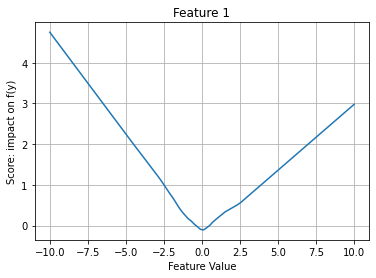

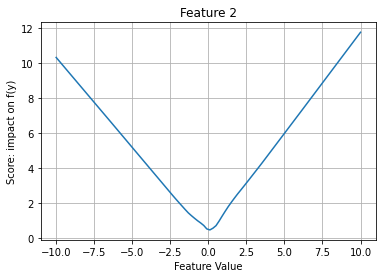

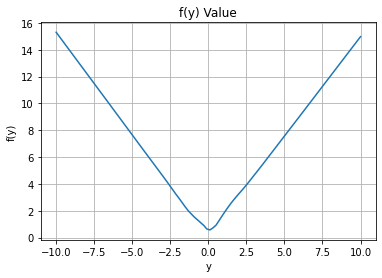

In [27]:
import matplotlib.pyplot as plt


x = torch.linspace(-10, 10, 100).reshape(-1, 1)
x = torch.hstack(2*[x]).double().to(device)
network = graphebm.interpretable_nn

linear_layer = network.get_submodule('lr').weight[0].detach().cpu().numpy()
features = network.get_submodule('features')(x).detach().cpu().numpy()

for i in range(2):
    plt.plot(
        x[:, 0].detach().cpu().numpy(),
        linear_layer[i].item() * features[:, i]
    )
    plt.title(f'Feature {i+1}')
    plt.xlabel("Feature Value")
    plt.ylabel("Score: impact on f(y)")
    plt.grid()
    plt.show()

output = network(x)
plt.plot(x[:, 0].detach().cpu().numpy(), output.detach().cpu().numpy())
plt.title("f(y) Value")
plt.xlabel("y")
plt.ylabel("f(y)")
plt.grid()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### TODO
* Add implementation of `~dig.ggraph.evaluation.metric.PropOptEvaluator` that considers multiple parameters (not just QED alone) to get the highest scoring generated objects.
* `run_prop_opt()` implementation a few cells above should handle multiple features/parameters instead of filtering on QED alone.
* Add code that calls our new evaluators and prints out metrics/scores, similar to `~examples.ggraph.GraphEBM.goal-directed_gen.ipynb`.

In case colab is disconnected when I start doing this, can upload epoch_20.pt and load the saved model.

In [32]:
class PropOptEvaluator:
    r"""
    Evaluator for property optimization task. Metric is top-3 property scores among generated molecules.
    Args:
        prop_name (str): A string indicating the name of the molecular property, use 'plogp' for penalized logP or 'qed' for 
            Quantitative Estimate of Druglikeness (QED). (default: :obj:`plogp`)
    """

    def __init__(self, prop_name='plogp', both=False):
        if both:
            self.prop_names = ['plogp', 'qed']
        else:
            assert prop_name in ['plogp', 'qed']
            self.prop_name = prop_name
            self.prop_names = None
    
    def eval(self, input_dict):
        r""" Run evaluation in property optimization task. Find top-3 molucules which have highest property scores.
        
        Args:
            input_dict (dict): A python dict with the following items:
                "mols" --- a list of generated molecules reprsented by rdkit Chem.Mol or Chem.RWMol objects.
            
        :rtype: :class:`dict` a python dict with the following items:
                    1 --- information of molecule with the highest property score;
                    2 --- information of molecule with the second highest property score;
                    3 --- information of molecule with the third highest property score.
                    The molecule information is given in the form of a tuple (SMILES string, property score).
        """
        def prop_fn_both(mol):
            return [qed(mol), calculate_min_plogp(mol)]

        mols = input_dict['mols']
        if self.prop_names:
            prop_fn = prop_fn_both
        else:
            prop_fn = qed if self.prop_name == 'qed' else calculate_min_plogp

        results = {}
        valid_mols = [mol for mol in mols if check_chemical_validity(mol)]
        valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
        props = [prop_fn(mol) for mol in valid_mols]
        
        if self.prop_names:
            sorted_index = np.argsort(props, axis=0)[::-1]
        else:
            sorted_index = np.argsort(props)[::-1]
        
        assert len(valid_mols) >= 3
        for i in range(3):
            print("Top {} property score: {}".format(i+1, props[sorted_index[i]]))
            results[i+1] = (valid_smiles[sorted_index[i]], props[sorted_index[i]])
        
        return results

In [ ]:
RDLogger.DisableLog('rdApp.error') 
RDLogger.DisableLog('rdApp.warning')

train_smiles = [data.smile for data in dataset[splits['train_idx']]]
initialization_loader = DenseDataLoader(train_set, batch_size=10000, shuffle=False, num_workers=0)
atomic_num_list = dataset.atom_list

save_mols_list, prop_list = graphebm.run_prop_opt(checkpoint_path, nn_checkpoint_path, initialization_loader=initialization_loader, c=0, ld_step=300, ld_noise=0.005, ld_step_size=0.2, clamp=True, atomic_num_list=atomic_num_list, train_smiles=train_smiles)
print(prop_list)
res_dict = {'mols':save_mols_list}
evaluator = PropOptEvaluator(both=True)
results = evaluator.eval(res_dict)
print(results)

Loading paramaters from /mnt/infonas/data/pritish/cs726/checkpoints_goal/energy_epoch_final.pt
Loading NN paramaters from /mnt/infonas/data/pritish/cs726/checkpoints_goal/inn_epoch_final.pt
In custom property optimization function.
